# LSTM Implementation in TreNet

### Authors: Nathan Ng, Gao Mo, Richard Tang

### LSTM Implementation

- LSTM model that feeds into linear layer that matches number of outputs as CNN stack
- Takes as input stock trend durations and slopes 

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Use GPU if available for PyTorch
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

## Data Pre-Processing

In [3]:
"""
Scales data using Sklearn's MinMaxScaler
Generalized to accept tensors 
"""
class Scaler():
    def __init__(self):
        self.scaler = MinMaxScaler()
        
    def fit_transform(self, data):
        # Check if data is tensor
        if type(data) == torch.Tensor:
            data = torch.Tensor.cpu(data).detach().numpy()
            
        # Check if data is dataframe 
        if type(data) == pd.DataFrame or type(data) == pd.Series:
            data = data.values
            
        # Transform data 
        if len(data.shape) == 1: 
            scaled_data = self.scaler.fit_transform(data.reshape(-1, 1)).flatten()
        else: 
            scaled_data = self.scaler.fit_transform(data)
        
        # Return tensor of scaled data
        return torch.tensor(scaled_data, dtype=torch.float)
    
    def inverse_transform(self, data): 
        # Check if data is tensor
        if type(data) == torch.Tensor:
            data = torch.Tensor.cpu(data).detach().numpy()
            
        # Check if data is dataframe 
        if type(data) == pd.DataFrame or type(data) == pd.Series:
            data = data.values
        
        inverse_data = self.scaler.inverse_transform(data)
        
        # Return tensor of inverse data
        return torch.tensor(inverse_data, dtype=torch.float)

In [4]:
"""
Extracts m sequential data to use to predict n next data 
"""
def extract_data(data, num_input, num_output):
    num_rows = data.shape[0] - num_input - num_output
    input_data = torch.zeros(num_rows, num_input)
    output_data = torch.zeros(num_rows, num_output)
    
    for i in range(num_rows):
        input_data[i] = (data[i:i+num_input])
        output_data[i] = (data[i+num_input:i+num_input+num_output])
    return input_data, output_data

In [5]:
"""
Separates data into train, validation, and test sets
props: (train, valid)
"""
def train_valid_test_split(X, y=None, props=None, device=None):
    if not props:
        props = (0.5, 0.25)
    elif len(props) != 3:
        print("Wrong number of parameters")
        return None

    train_size = int(X.shape[0] * props[0])
    valid_size = int(X.shape[0] * props[1])

    X_train = X[:train_size].to(device)
    X_valid = X[train_size: (train_size + valid_size)].to(device)
    X_test = X[(train_size + valid_size):].to(device)

    if y != None:
        y_train = y[:train_size].to(device)
        y_valid = y[train_size: (train_size + valid_size)].to(device)
        y_test = y[(train_size + valid_size):].to(device)

        return X_train, y_train, X_valid, y_valid, X_test, y_test

    return X_train, X_valid, X_test

## TreNet LSTM Model

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, device=None):
        super(LSTM, self).__init__()

        # Initialize hidden dimenision and layers
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim

        # Initialize deep learning models
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True).to(device)
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        self.device = device

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)

        # Reshape data if needed
        if len(x.shape) != 3:
            x = x.reshape(x.shape[0], -1, self.input_dim).to(self.device)

        # Run data through model
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

## TreNet LSTM Training

In [96]:
"""
Create training loop
"""
def train_loop(n_epochs, X, y, model, loss_fn, optimizer, X_val=None, y_val=None, printout=False, record_loss=False):
    train_losses = []
    best_model = None
    best_loss = float("inf")
    validation = False
    
    # Add data for validation loss
    if X_val is not None and y_val is not None: 
        validation = True
        val_losses = []
    
    for i in range(n_epochs):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Compute validation loss 
        if validation:
            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, y_val)
            
        # Store best performing model
        if validation: 
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                best_model = model.state_dict()
                torch.save(model.state_dict(), "best_model")
        else:
            if loss.item() < best_loss: 
                best_loss = loss.item()
                best_model = model.state_dict()
                torch.save(model.state_dict(), "best_model")
                

        # Perform backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss per epoch
        if printout and i % 100 == 0:
            print(f"Epoch {i}:\n--------------")
            print(f"Train Loss: {np.sqrt(loss.item())}")
            
            if val_loss is not None:
                print(f"Validation Loss: {np.sqrt(val_loss.item())}")

            print()

        # Record loss per epoch
        if record_loss:
            train_losses.append(np.sqrt(loss.item()))
            if validation:
                val_losses.append(np.sqrt(val_loss.item()))
    
    # Calculate final model losses 
    pred = model(X)
    final_train_loss = loss_fn(pred, y)
    
    if validation:
        val_pred = model(X_val)
        final_val_loss = loss_fn(val_pred, y_val)
    
    # Update model to best performing model
    model.load_state_dict(torch.load("best_model"))
    pred = model(X)
    best_train_loss = loss_fn(pred, y)
    
    if validation:
        val_pred = model(X_val)
        best_val_loss = loss_fn(val_pred, y_val)

    # Print final loss after training and best performing model 
    if printout:
        print(f"Final:\n--------------")
        print(f"Train Loss: {np.sqrt(final_train_loss.item())}")
        if validation:
            print(f"Validation Loss: {np.sqrt(final_val_loss.item())}")
        print()
        
        print(f"Best Model:\n--------------")
        print(f"Train Loss: {np.sqrt(best_train_loss.item())}")
        if validation:
            print(f"Validation Loss: {np.sqrt(best_val_loss.item())}")
        print()

    if record_loss: 
        if validation:
            return train_losses, val_losses
        else:
            return train_losses

## Test LSTM Model on Raw Stock Prices

In [97]:
# Load in NYSE data
df = pd.read_csv("../data/raw/indexProcessed.csv")
NYSE_df = df[df["Index"] == "NYA"].loc[:, "Open"].reset_index(drop=True)

# Create subset of data 
NYSE_sub = NYSE_df[:1000]

In [98]:
# Scale data 
scaler = Scaler()
sub = scaler.fit_transform(NYSE_sub).to(device)

In [99]:
# Extract samples and create train test sets
X, y = extract_data(sub, 49, 1)
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y, device=device)

In [100]:
# Set parameters for model and training 
input_dim = 1
hidden_dim = 32
num_layers = 1
output_dim = 1

learning_rate = 0.01
num_epochs = 1000

In [101]:
# Initialize model, loss function, and optimizer
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, device=device)
loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [102]:
# Train model
losses = train_loop(num_epochs, X_train, y_train, model, loss_fn, optimizer, printout=True, record_loss=True, X_val = X_valid, y_val = y_valid)

Epoch 0:
--------------
Train Loss: 0.4054621613248329
Validation Loss: 0.701968831951709

Epoch 100:
--------------
Train Loss: 0.02297416305335471
Validation Loss: 0.024583437615773834

Epoch 200:
--------------
Train Loss: 0.020452765399284804
Validation Loss: 0.0238516288571945

Epoch 300:
--------------
Train Loss: 0.01857707044474476
Validation Loss: 0.020738318816857112

Epoch 400:
--------------
Train Loss: 0.01743390605534811
Validation Loss: 0.019369173355080656

Epoch 500:
--------------
Train Loss: 0.016884484432144888
Validation Loss: 0.018615638232430554

Epoch 600:
--------------
Train Loss: 0.016428816551191466
Validation Loss: 0.01845795030551108

Epoch 700:
--------------
Train Loss: 0.015991786953692785
Validation Loss: 0.018535335701193336

Epoch 800:
--------------
Train Loss: 0.015531389422403733
Validation Loss: 0.018665742118841786

Epoch 900:
--------------
Train Loss: 0.015310397610494568
Validation Loss: 0.018712245349431004

Final:
--------------
Train Loss:

In [ ]:
# Compare predictions and actual values 
inverse_test_y = scaler.inverse_transform(y_test)

pred_test_y = model(X_test)
inverse_pred_test_y = scaler.inverse_transform(pred_test_y)

In [ ]:
print("Test Loss: " + str(loss_fn(inverse_pred_test_y, inverse_test_y)**(1/2)))

print("Actual values: \n" + str(inverse_test_y[:10]))

print("Predicted values: \n" + str(inverse_pred_test_y[:10]))

In [ ]:
# Save training loss as csv 
pd.DataFrame(training_loss).to_csv("../data/losses/lstm_loss.csv", index=False)

## Saving Model and Restoring Model State

In [24]:
best_model = model.state_dict()

In [82]:
model_2 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, device=device)
# model_2.load_state_dict(best_model)

In [26]:
model_2.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.2722],
                      [-0.1052],
                      [ 0.2542],
                      [ 0.2783],
                      [-0.3370],
                      [ 0.2374],
                      [ 0.0372],
                      [ 0.2592],
                      [ 0.3185],
                      [-0.0600],
                      [ 0.3775],
                      [ 0.3695],
                      [ 0.1134],
                      [ 0.1399],
                      [ 0.1551],
                      [-0.4466],
                      [ 0.3496],
                      [-0.0355],
                      [ 0.0471],
                      [-0.1455],
                      [-0.2234],
                      [ 0.2945],
                      [-0.3681],
                      [ 0.2337],
                      [ 0.5413],
                      [ 0.2862],
                      [ 0.2962],
                      [ 0.3796],
                      [ 0.4161],
        

In [85]:
model_2.load_state_dict(dict(model.state_dict()))

<All keys matched successfully>

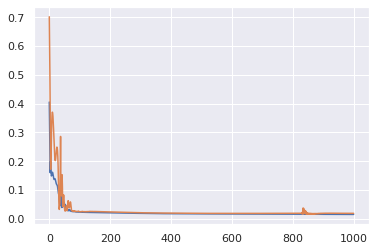

In [111]:
sns.set()
plt.plot(losses[0])
plt.plot(losses[1])
plt.show()